In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import least_squares

# Saha EOS

$$
C_\text{Saha} = \bigl(\frac{2\pi m_e k_B}{h^2}\bigr)^\frac{3}{2}
$$

In [2]:
SAHA_CONST = 2.4146830395719654e+21 # /m^3

def generate_saha_equations(T):
    "Generates Saha equations for the given absolute temperature."
    # Beryllium
    K   = SAHA_CONST * T**(3/2)
    EPS = np.finfo(float).eps
    kB  = 8.617333e-5    # eV/K

    e1  =   9.3227  / kB # eV scaled to K
    e2  =  18.21116 / kB # eV scaled to K
    e3  = 153.89661 / kB # eV scaled to K
    e4  = 217.71865 / kB # eV scaled to K

    c1 = min(K * np.exp(-e1/T), 1e8)
    c2 = min(K * np.exp(-e2/T), 1e8)
    c3 = min(K * np.exp(-e3/T), 1e8)
    c4 = min(K * np.exp(-e4/T), 1e8)

    c1 = max(c1, 1e-8)
    c2 = max(c2, 1e-8)
    c3 = max(c3, 1e-8)
    c4 = max(c4, 1e-8)
    
    def saha_equations(args):
        f0, f1, f2, f3, f4, fe = args[:]
        # auxiliary condition 1 (should be zero)
        # conservation of atoms (fraction, all divided by total)
        a1 = f0 + f1 + f2 + f3 + f4 - 1
    
        # auxiliary condition 2 (should be zero)
        # conservation of charge
        a2 = f1 + 2*f2 + 3*f3 + 4*f4 - fe

        # Boltzmann conditions (should be zero)
        b1 = f1*fe - f0*c1
        b2 = f2*fe - f1*c2
        b3 = f3*fe - f2*c3
        b4 = f4*fe - f3*c4

        return a1, a2, b1, b2, b3, b4

    return saha_equations

def saha(T):
    e = generate_saha_equations(T)
    #          f0   f1   f2   f3   f4   fe
    minvals = (0.0, 0.0, 0.0, 0.0, 0.0, 0.0)
    initial = (0.1, 0.1, 0.1, 0.1, 0.1, 0.5)
    maxvals = (1.0, 1.0, 1.0, 1.0, 1.0, 4.0)
    result = least_squares(e, initial, bounds=(minvals, maxvals))
    return result.x

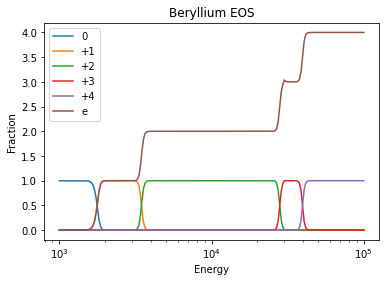

In [3]:
temps = np.logspace(3, 5, 200)
# Can't call it like a ufunc, so I'm improvising.
fractions = np.vstack([saha(T) for T in temps])

plt.semilogx(temps, fractions[:, 0], label="0")
plt.semilogx(temps, fractions[:, 1], label="+1")
plt.semilogx(temps, fractions[:, 2], label="+2")
plt.semilogx(temps, fractions[:, 3], label="+3")
plt.semilogx(temps, fractions[:, 4], label="+4")
plt.semilogx(temps, fractions[:, 5], label="e")

plt.legend(loc="best")
plt.xlabel("Energy")
plt.ylabel("Fraction")
plt.title("Beryllium EOS")
plt.show()